In [1]:
import os

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import data_tools

from crop_rasters import crop

In [2]:
!pwd

/home/jakidxav/Desktop/jakidxav


In [3]:
#locate the files, and only get the '_refl.tif' files
#data_dir = '/home/jovyan/ghw2019_planetpieces/data/'
data_dir = '/home/jakidxav/Desktop/jakidxav/data/'

data_list = []

filenames = os.listdir(data_dir)

for filename in filenames:
    if filename.endswith('Analytic_refl.tif'):
        data_list.append(filename)

In [4]:
#print out the first five files
data_list[:5]

['2412728_1060619_2019-06-02_0e26_BGRN_Analytic_refl.tif',
 '2412593_1060618_2019-06-02_0f4d_BGRN_Analytic_refl.tif',
 '2548338_1060618_2019-07-25_1049_BGRN_Analytic_refl.tif',
 '2413944_1060719_2019-06-02_1061_BGRN_Analytic_refl.tif',
 '2412728_1060719_2019-06-02_0e26_BGRN_Analytic_refl.tif']

In [5]:
print(len(data_list))

20


In [6]:
#now let's open up each file, and get the green channel
#data shape should be (1, 8000, 8000), create a mask of the same shape
images = []
labels = []

for i, filename in enumerate(data_list[:20]):
    #open the raster data
    data = data_tools.read_raster(data_dir+filename, band=None)[0]
    
    #get the RGB channels
    img = data[0:3]
        
    #create mask from threshold value using the green channel
    mask = np.zeros(np.shape(img[1]))
    
    mask[img[1] > 2500] = 1
    
    #append the data and labels to list
    images.append(img)
    labels.append(mask)
    
    print('Done processing file {}/20'.format(i+1))

Done processing file 1/20
Done processing file 2/20
Done processing file 3/20
Done processing file 4/20
Done processing file 5/20
Done processing file 6/20
Done processing file 7/20
Done processing file 8/20
Done processing file 9/20
Done processing file 10/20
Done processing file 11/20
Done processing file 12/20
Done processing file 13/20
Done processing file 14/20
Done processing file 15/20
Done processing file 16/20
Done processing file 17/20
Done processing file 18/20
Done processing file 19/20
Done processing file 20/20


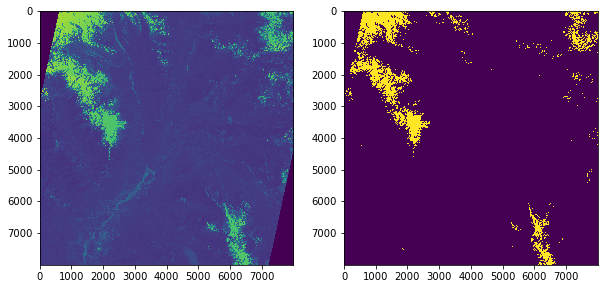

In [7]:
fix, ax = plt.subplots(1, 2, figsize=(10, 10))

ax[0].imshow(images[0][1])
ax[1].imshow(labels[0])

plt.show()

In [8]:
images_small, labels_small = crop(images, labels)

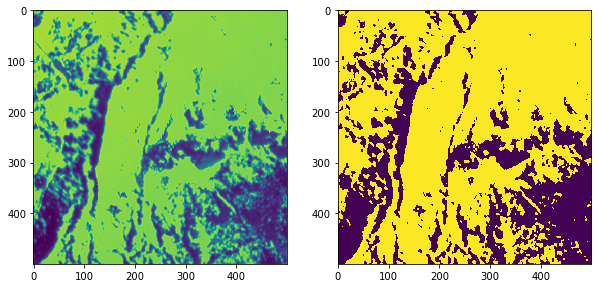

In [10]:
fix, ax = plt.subplots(1, 2, figsize=(10, 10))

ax[0].imshow(images_small[0][1])
ax[1].imshow(labels_small[0])

plt.show()

In [11]:
#first, we need to split the data into training, validation, and test sets
traindata, trainlabels = images_small[:10], labels_small[:10]
valdata, vallabels = images_small[10:15], labels_small[10:15]
testdata, testlabels = images_small[15:], labels_small[15:]

In [12]:
print(np.shape(traindata), np.shape(trainlabels))

(10, 3, 500, 500) (10, 500, 500)


In [13]:
traindata = np.transpose(traindata, (0, 2, 3, 1))
valdata = np.transpose(valdata, (0, 2, 3, 1))
testdata = np.transpose(testdata, (0, 2, 3, 1))

trainlabels = np.expand_dims(trainlabels, axis=3)
vallabels = np.expand_dims(vallabels, axis=3)
testlabels = np.expand_dims(testlabels, axis=3)

In [14]:
print(np.shape(traindata), np.shape(trainlabels))

(10, 500, 500, 3) (10, 500, 500, 1)


In [17]:
#save the data so that we don't have to redo that processing step
# np.save('traindata.npy', traindata)
# np.save('trainlabels.npy', trainlabels)

# np.save('valdata.npy', valdata)
# np.save('vallabels.npy', vallabels)

# np.save('testdata.npy', testdata)
# np.save('testlabels.npy', testlabels)

print('The data is saved to numpy arrays.')

The data is saved to numpy arrays.


In [2]:
#load the data if the kernel dies or we need to restart the notebook
traindata = np.load('./traindata.npy')
trainlabels = np.load('./trainlabels.npy')

valdata = np.load('./valdata.npy')
vallabels = np.load('./vallabels.npy')

testdata = np.load('./testdata.npy')
testlabels = np.load('./testlabels.npy')

# Transfer Learning in Tensorflow 2.0

Now that we have our data, we need to train our network. However, building and training a model from scratch is time and compute intensive. There are already many neural network architectures that have proven to do well that we can use. Here, I am going to load in a ResNet50 architecture  in Tensorflow and use the ImageNet weights. Then I can retrain the output layer to predict on my satellite data.

Thank you to to the [Tensorflow Docs](https://www.tensorflow.org/tutorials/images/transfer_learning) and [this](https://lambdalabs.com/blog/tensorflow-2-0-tutorial-02-transfer-learning/) blog post which helped me get started with transfer learning in Tensorflow.

You can see which models are available for use on the [Keras Applications](https://keras.io/applications/) page.

In [16]:
#import the architecture and weights here
backbone = tf.keras.applications.vgg16.VGG16(weights="imagenet", include_top=False, input_shape=(500, 500, 3))

#then freeze those weights for training
#we don't want to change these weights, but only the weights from the output layer
backbone.trainable = False

In [17]:
#let's inspect the architecture
backbone.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 500, 500, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 500, 500, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 500, 500, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 250, 250, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 250, 250, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 250, 250, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 125, 125, 128)     0     

In [50]:
#now let's replace the classifier which will predict on two classes
model = tf.keras.Sequential([
  backbone,
  tf.keras.layers.GlobalAveragePooling2D(), 
  tf.keras.layers.Dense(units=5*500*500, activation='sigmoid'),
])

In [51]:
print(model.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 15, 15, 512)       14714688  
_________________________________________________________________
global_average_pooling2d_9 ( (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1250000)           641250000 
Total params: 655,964,688
Trainable params: 641,250,000
Non-trainable params: 14,714,688
_________________________________________________________________
None


In [63]:
epochs = 1

#https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam
optimizer = tf.keras.optimizers.Adam()
loss = 'sparse_categorical_crossentropy'

#compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [64]:
#verbose=1 gives a progress bar during training
history = model.fit(valdata, vallabels, epochs=epochs, verbose=1)#, validation_data=(valdata, vallabels))

In [ ]:
#now let's plot the accuracy and loss across epochs
#helpful link: https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

#plot accuracy for 
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])

# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')

# plt.show()

In [ ]:
#plot loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])

# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')

# plt.show()